In [61]:
import pandas as pd
#import polars as ps

import numpy as np

from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [62]:
def compute_msd(trajectory):
        totalsize=len(trajectory)
        msd=[]
        for i in range(totalsize-1):
            j=i+1
            msd.append(np.sum((trajectory[0:-j]-trajectory[j::])**2)/float(totalsize-j)) # Distance that a particle moves for each time point divided by time
        msd=np.array(msd)
        rmsd = np.sqrt(msd)
        return msd, rmsd 

In [63]:
import math
dt = 0.1

def logD_from_mean_MSD(MSDs):
        mean_msd = 0
        logD = 0

        mean_track=np.mean(MSDs[0:3])
        if mean_track!=0:
            mean_msd = mean_track
        else:
            mean_msd = 0.000000001
    
        logD = math.log10(mean_track/(dt*4)) # 2*2dimnesions* time
        return mean_msd, logD

In [70]:

from matplotlib.path import Path
import os
from os import listdir
from os.path import isfile, join
import pandas as pd


def load_all(folderpath1):
    count=0
    onlyfiles = [f for f in listdir(folderpath1) if isfile(join(folderpath1, f))]
    for i in onlyfiles:
        if i.endswith(".csv"):
            path=os.path.join(folderpath1, i)
            print(path)
            df=pd.read_csv(path)
            if count==0:
                tracks=df
            else:
                df["TRACK_ID"] = df["TRACK_ID"] + len(tracks["TRACK_ID"].unique())
            
                tracks = pd.concat([tracks, df], ignore_index=True, axis=0)
            count+=1
    return tracks


                   

In [71]:
def plot_track(id, tracks):
    one_track_xy = tracks[tracks['TRACK_ID'] == id]
    truth = tracks[tracks['TRACK_ID'] == id]["GT"]
    x, y = np.array(one_track_xy["POSITION_X"]), np.array(one_track_xy["POSITION_Y"])

    li = list(zip(x, y))
    plt.plot(*zip(*li))
    plt.scatter(*zip(*li), c = truth)
    for i in range(len(one_track_xy)):
        plt.annotate(i, (x[i], y[i]))

In [72]:
def preprocess_track(tracks, track_id, window_size):
    one_track_xy = tracks[tracks['TRACK_ID'] == track_id]
    truth = tracks[tracks['TRACK_ID'] == track_id]["GT"]
    x, y = np.array(one_track_xy["POSITION_X"]), np.array(one_track_xy["POSITION_Y"])

    m=np.column_stack((x,y))
    sliding_msds = []
    sliced_x=[]
    sliced_y=[]
    
    logDs = []
    alphas=[]
    gaussians=[]
    for i in range(len(m) - window_size + 1):
        sliced_m = m[i: i + window_size]
        sliced_x=list(x[i: i + window_size])
        sliced_y=list(y[i: i + window_size])
        msds, rmsd = compute_msd(sliced_m)
        _, logD = logD_from_mean_MSD(msds)
     
        sliding_msds.append(np.mean(msds))
        logDs.append(logD)
     
       

    steps = np.sqrt((x[1:] - x[:-1]) ** 2 + (y[1:] - y[:-1]) ** 2)

    #cut off the last part so its all the same length as msd sequence
    seq_len = len(sliding_msds)
    steps = steps[:seq_len]
    truth = truth[:seq_len]
    logDs = logDs[:seq_len]


    return sliding_msds, steps, logDs, truth

In [73]:
def plot_features(track_id, data):
    fig, axs = plt.subplots(4)
    axs[0].plot(data[track_id][0])
    axs[1].plot(data[track_id][1])
    axs[2].plot(data[track_id][2])
    
#cluster_tracks = tracks.loc[tracks['GT'] == 0, 'TRACK_ID'].reset_index()
#cluster_tracks["TRACK_ID"].unique()

In [74]:
def preprocess_wrapper(window_size, tracks):

    preprocessed_tracks = []
    truths = []
    lengths = []

    for i in tracks["TRACK_ID"].unique():

        sliding_msds, steps, logD, truth = preprocess_track(tracks,i, window_size)

        track_features = [sliding_msds, steps, logD]

        preprocessed_tracks.append(track_features)
        truths.append(truth)
        lengths.append(len(sliding_msds))

    preprocessed_tracks = np.array(preprocessed_tracks)

    print(preprocessed_tracks.shape)
    print("heere", lengths)

    # Step 1: Separate the two feature vectors
    msd = preprocessed_tracks[:, 0, :]
    steplength = preprocessed_tracks[:, 1, :]
    logD = preprocessed_tracks[:, 2, :]

    # Step 2: Scale each feature vector independently
    scaler = StandardScaler()

    scaled_msd = scaler.fit_transform(msd)
    scaled_steplength = scaler.fit_transform(steplength)
    scaled_logD = scaler.fit_transform(logD)


    scaled_data = np.stack((scaled_msd, scaled_steplength, scaled_logD), axis=1)

    print(scaled_data.shape)



    return preprocessed_tracks, scaled_data, lengths, truths

X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all\D0.001_N500_T200_for_philip_simulated_tracks_0_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all\D0.001_N500_T200_for_philip_simulated_tracks_10_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all\D0.001_N500_T200_for_philip_simulated_tracks_11_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all\D0.001_N500_T200_for_philip_simulated_tracks_1_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all\D0.001_N500_T200_for_philip_simulated_tracks_2_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all\D0.001_N500_T200_for_philip_simulated_tracks_3_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all\D0.001_N500_T200_for_philip_simulated_tracks_4_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all\D0.001_N500_T200_for_philip_simulated_tracks_5_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks

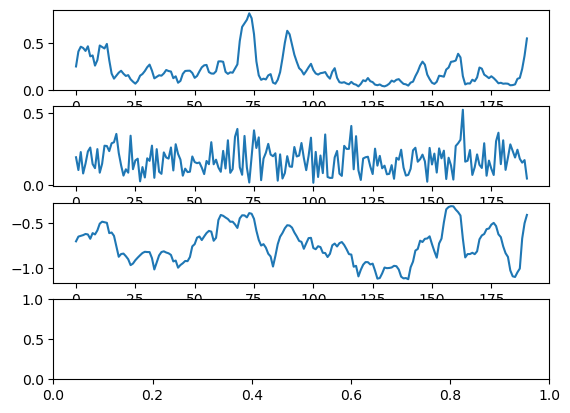

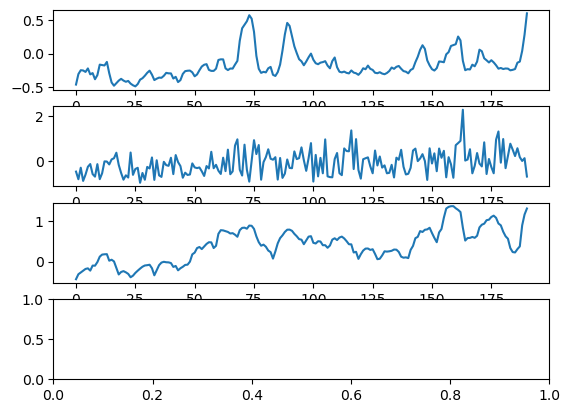

In [75]:

# run this to preprocess al files in a folder for training:
def preprocess_wrapper_for_training(folder_path, windowsize):
    tracks=load_all(path)
    preprocessed_tracks, scaled_data, lengths, truths=preprocess_wrapper(windowsize, tracks)
    concat_data = np.concatenate(scaled_data, axis = 1)
    concat_data = concat_data.T
    concat_data.shape
    lengths = np.array(lengths)
    truths = np.array(truths)
    
    
    return concat_data, lengths, truths, preprocessed_tracks, scaled_data, tracks

    
path=r"X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all"
w=10
concat_data, lengths, truths, preprocessed_tracks, scaled_data, tracks=preprocess_wrapper_for_training(path, w)

# look at them:
id = 1
#plot_track(id)
plot_features(id, preprocessed_tracks)
plot_features(id, scaled_data)


In [76]:
# Define and train the model on the concatenated time series

scores = list() # To store scores of models
models = list() # To store models

for idx in tqdm(range(10)):  # Ten different random starting states
        # Define hidden Markov model
        model = hmm.GaussianHMM(n_components=4, random_state=idx,
                            n_iter=100, algorithm="viterbi", init_params="cms", params="cms")
        #model.transmat_ = np.array([[0.95, 0.05],
                               #[0.05, 0.95]])
        #model.transmat_ = np.array([[0.95, 0.05, 0.0, 0.0],
                               # [0.25, 0.5, 0.25, 0],
                               # [0.05, 0.25, 0.5, 0.2],
                               # [0.0, 0.25, 0.25, 0.5]])
        model.fit(concat_data, lengths= lengths)
        models.append(model)
        scores.append(model.score(concat_data))
        print(f'Converged: {model.monitor_.converged}\t\t'
            f'Score: {scores[-1]}')

# Get the best model
model = models[np.argmax(scores)]
print(f'The best model had a score of {max(scores)} and '
      f'{model.n_components} components')

 10%|█         | 1/10 [01:16<11:25, 76.21s/it]

Converged: True		Score: -2006923.423238423


 20%|██        | 2/10 [02:08<08:14, 61.87s/it]

Converged: True		Score: -5936612.34295387


 30%|███       | 3/10 [04:55<12:51, 110.22s/it]

Converged: True		Score: -3384745.313585838


 40%|████      | 4/10 [06:10<09:36, 96.01s/it] 

Converged: True		Score: -5788406.796535619


 50%|█████     | 5/10 [08:59<10:13, 122.63s/it]

Converged: True		Score: -3239739.7222837326


 60%|██████    | 6/10 [11:24<08:40, 130.11s/it]

Converged: True		Score: -4041148.7224949575


 70%|███████   | 7/10 [14:10<07:05, 141.77s/it]

Converged: True		Score: -3629227.252374489


 80%|████████  | 8/10 [15:16<03:55, 117.72s/it]

Converged: True		Score: -3853109.929282872


 90%|█████████ | 9/10 [17:07<01:55, 115.59s/it]

Converged: True		Score: -3368660.095908072


100%|██████████| 10/10 [18:09<00:00, 108.93s/it]

Converged: True		Score: -4576926.955204549
The best model had a score of -2006923.423238423 and 4 components


In [77]:
# Initialize an empty list to store the predicted states for each sequence
predicted_states = []

# Keep track of where each sequence starts and ends in the concatenated array
start_idx = 0

# Iterate over each track by using the lengths array
for length in lengths:
    # Extract the specific sequence from concatenated_series using start_idx and length
    sequence = concat_data[start_idx:start_idx + length]
    
    # Reshape the sequence to 2D (needed by the HMM model)
    sequence_reshaped = sequence
    
    # Predict the hidden states for this sequence
    states = model.predict(sequence_reshaped)
    
    # Append the predicted states for this sequence to the list
    predicted_states.append(states)
    
    # Move to the start index of the next sequence
    start_idx += length

In [78]:
predicted_states = np.array(predicted_states)
predicted_states.shape

(12000, 191)

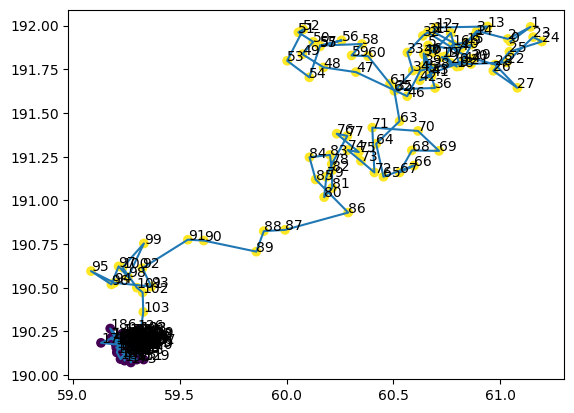

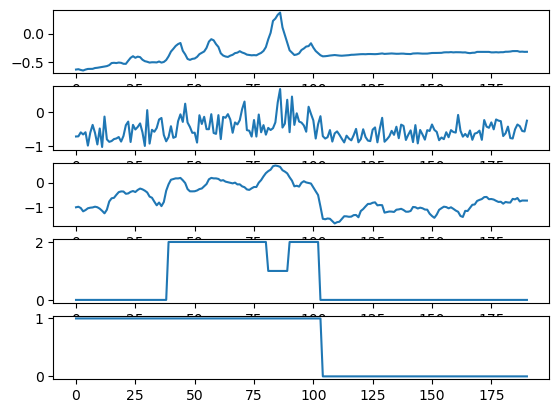

In [79]:
## look at them to check which is state zeros 
#path=r"X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\train_all"

#tracks=load_all(path)



id=500
plot_track(id, tracks)
fig, axs=plt.subplots(5)
axs[0].plot(scaled_data[id][0])
axs[1].plot(scaled_data[id][1])
axs[2].plot(scaled_data[id][2])
axs[3].plot(predicted_states[id])
axs[4].plot(truths[id])

In [84]:
## save andload the model:

import pickle

with open("model_3.pkl", "wb") as file: 
    pickle.dump(model, file)

with open("model_3.pkl", "rb") as file: 
    model = pickle.load(file)

In [81]:
# make precision:
from sklearn import metrics
from itertools import chain
from math import nan

# for 4 states: where its reversed
# 0->1
#1-> 1
#2->0
# 3->0

# for 4 states: where its normal
# 0->0
#1-> 1
#2->1
# 3->1
def calculate_precision(predicted_states, truths):
    predicted_states_flat= list(chain.from_iterable(predicted_states))
    #print(predicted_states_flat)

    df_predict=pd.DataFrame(predicted_states_flat, columns=["states" ])
    #print(df_predict)
    
    

    df_predict["states"]= df_predict["states"].replace(2,1)
    #df_predict["states"]= df_predict["states"].replace(2,0)
    df_predict["states"]= df_predict["states"].replace(3,1)


    arry_predict=df_predict["states"]
    
    arry_truths= list(chain.from_iterable(truths))
    #print(arry_predict)
    #print(truths)

    precision, recall, fbeta, support=metrics.precision_recall_fscore_support(arry_truths, arry_predict, pos_label=0)
    try:
        precision_confined=precision[0]
    except IndexError:
        precision_confined=nan
    try:
        precision_unconfined=precision[1]
    except IndexError:
        precision_unconfined=nan
    try:
        recall_confined=recall[0]
    except IndexError:
        recall_confined=nan
    try:
        recall_unconfined=recall[1]
    except IndexError:
        recall_unconfined=nan
    try:
        fbeta_confined=fbeta[0]
    except IndexError:
        fbeta_confined=nan
    try:
        fbeta_unconfined=fbeta[1]
    except IndexError:
        fbeta_unconfined=nan
    try:
        support_confined=support[0]
    except IndexError:
        support_confined=nan
    try:
        support_unconfined=support[0]
    except IndexError:
        support_unconfined=nan
    print("precision_confined",precision_confined )
    print("precision_unconfined",precision_unconfined )
    print("recall_confined",recall_confined)
    print("recall_unconfined",recall_unconfined)

    return precision_confined, precision_unconfined, recall_confined, recall_unconfined


#calculate_precision(predicted_states, truths)

# for 4 states, 20 random : precision= 0.5971465403383343
# for 4 states, 20 random : where not reversed trained on 3 track files: only 0=0, rest =1: precision_confined 0.9553926285403506


In [83]:
### evaluete on new tracks!


##for all track sindividually:


def test_model(tracks, window_size):
    preprocessed_tracks, scaled_data, lengths, truths=preprocess_wrapper(window_size, tracks)

    print("heere2",scaled_data.shape)
    concat_data = np.concatenate(scaled_data, axis = 1)
    concat_data = concat_data.T
    lengths = np.array(lengths)
    truths = np.array(truths)

    predicted_states = []

    # Keep track of where each sequence starts and ends in the concatenated array
    start_idx = 0

    # Iterate over each track by using the lengths array
    for length in lengths:
        # Extract the specific sequence from concatenated_series using start_idx and length
        sequence = concat_data[start_idx:start_idx + length]
        
        # Reshape the sequence to 2D (needed by the HMM model)
        sequence_reshaped = sequence
        
        # Predict the hidden states for this sequence
        states = model.predict(sequence_reshaped)
        
        # Append the predicted states for this sequence to the list
        predicted_states.append(states)
        
        # Move to the start index of the next sequence
        start_idx += length
    predicted_states = np.array(predicted_states)
    predicted_states.shape
    p1, p2, r1, r2=calculate_precision(predicted_states, truths)

    return p1, p2, r1, r2


#test_model(tracks0)

def test_individually(list_paths):
    for i in list_paths:
        print(i)
        tracks0 = pd.read_csv(i)
        print(tracks0)
        p1, p2, r1, r2=test_model(tracks0)
    print("done")

    return list_paths



folder=r"X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all"

tracks_test=load_all(folder)

print(tracks_test.shape)

w=10
test_model(tracks_test, w)



X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all\D0.001_N500_T200_for_philip_simulated_tracks_0_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all\D0.001_N500_T200_for_philip_simulated_tracks_10_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all\D0.001_N500_T200_for_philip_simulated_tracks_11_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all\D0.001_N500_T200_for_philip_simulated_tracks_1_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all\D0.001_N500_T200_for_philip_simulated_tracks_2_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all\D0.001_N500_T200_for_philip_simulated_tracks_3_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all\D0.001_N500_T200_for_philip_simulated_tracks_4_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_model\test_all\D0.001_N500_T200_for_philip_simulated_tracks_5_.csv
X:\labs\Lab_Gronnier\Michelle\simulated_tracks\HMM_mod

c:\Users\bcgvm01\.conda\envs\deep_SPT\Lib\site-packages\sklearn\metrics\_classification.py:1549: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


precision_confined 0.8084986326392425
precision_unconfined 0.6944196796230983
recall_confined 0.5685633605256358
recall_unconfined 0.8792296997583502


(0.8084986326392425,
 0.6944196796230983,
 0.5685633605256358,
 0.8792296997583502)

In [101]:
# Transition matrix (probabilities of moving between hidden states)
transition_matrix = model.transmat_
print("Transition Matrix:")
print(transition_matrix)

# Emission parameters for each hidden state
emission_means = model.means_
emission_covariances = model.covars_
print("\nEmission Means (one for each hidden state):")
print(emission_means)
print("\nEmission Covariances (one for each hidden state):")
print(emission_covariances)

#precision_confined 0.9183323327260683
#precision_unconfined 0.9218674299075263
#recall_confined 0.8567258944522235
#recall_unconfined 0.9568736505507119

precision_confined 0.8095667929587855
precision_unconfined 0.6907705674431459
recall_confined 0.5639001262072648
recall_unconfined 0.8801568299162782

Transition Matrix:
[[8.20307797e-01 1.42628223e-01 3.70549180e-02 9.06215842e-06]
 [4.30221158e-08 9.52355734e-02 8.93087849e-01 1.16765349e-02]
 [2.45598630e-03 5.30021116e-03 9.30764284e-01 6.14795189e-02]
 [2.44108257e-02 7.02811984e-08 7.91457988e-02 8.96443305e-01]]

Emission Means (one for each hidden state):
[[-1.80464887 -1.36818645 -4.05662443]
 [ 2.19013863  0.16012515  1.55792959]
 [ 0.3788984   0.09851409  0.51926065]
 [-0.71276748 -0.06714249 -0.62351244]]

Emission Covariances (one for each hidden state):
[[[0.0075802  0.         0.        ]
  [0.         0.07355144 0.        ]
  [0.         0.         0.28775018]]

 [[0.63451456 0.         0.        ]
  [0.         1.10608139 0.        ]
  [0.         0.         0.10130125]]

 [[0.21469515 0.         0.        ]
  [0.         1.04266942 0.        ]
  [0.         0.         0.12253802]]

 [[0.09569713 0.         0.        ]
  [0.         0.88351848 0.        ]
  [0.         0.         0.22793248]]]


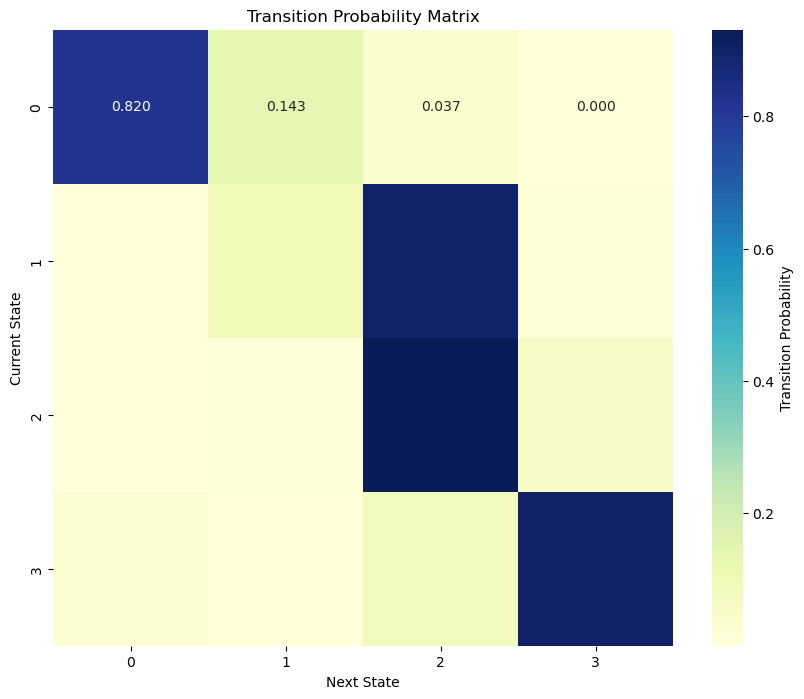

In [ ]:
# Plotting the transition probability matrix (for transitions between different states)
plt.figure(figsize=(10, 8))
sns.heatmap(
    transition_matrix, 
    annot=True,
    cmap="YlGnBu", 
    cbar_kws={'label': 'Transition Probability'},
    fmt=".3f"
)

plt.title("Transition Probability Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()